In [60]:
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from scipy import stats

In [61]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Evtisov_SS\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
df = pd.read_csv('credit_card_default_analysis.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

## Task 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 
* a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 
* b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [38]:
df_default0=df[df.default==0]['LIMIT_BAL']
df_default1=df[df.default==1]['LIMIT_BAL']

### 1.1. Проверим равенство средних по Критерию Стьюдента:

$H_0\colon$ средние значения кредитного лимита одинаково для тех, кто вернул кредит и тех, кто не вернул

$H_1\colon$ не одинаково.

Проверим, что распределения в выборках существенно не отличаются от нормальных. Проверяем визуально, поскольку 
Критерий Шапиро-Уилка не применим из-за большого объхема выборки

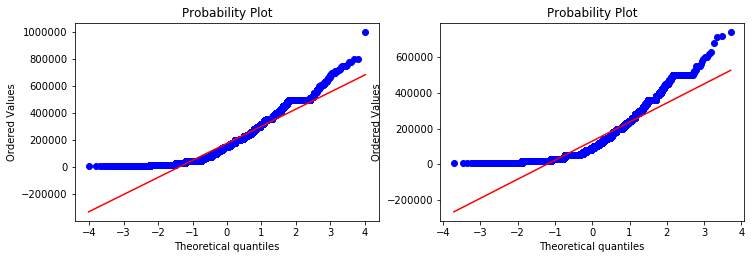

In [72]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(df_default0, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(df_default1, dist="norm", plot=pylab)
pylab.show()

Используем Двухвыборочный критерий Стьюдента (независимые выборки) 

In [75]:
stats.ttest_ind(df_default0, df_default1, equal_var = False)

Ttest_indResult(statistic=28.951587933509845, pvalue=3.3641002455114717e-178)

Получается, что нулевая гипотиза не отвергается - возврат кредита не зависит от кредитного лимита

In [44]:
stats.mannwhitneyu(df_default0, df_default1)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.1277429091116516e-190)

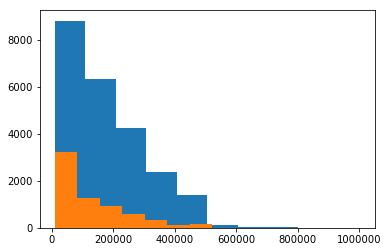

In [51]:
plt.hist(df_default0)
plt.hist(df_default1)
plt.show()

In [58]:
df_default0.sort_values(axis=0)

26928      10000
25178      10000
25181      10000
8443       10000
29379      10000
2212       10000
15919      10000
21018      10000
8490       10000
14506      10000
8498       10000
29393      10000
4653       10000
8504       10000
10648      10000
2242       10000
8548       10000
20949      10000
2253       10000
14514      10000
16988      10000
25220      10000
12580      10000
16950      10000
29416      10000
25200      10000
4510       10000
2196       10000
8416       10000
2038       10000
          ...   
1231      680000
23096     690000
23440     700000
7312      700000
811       700000
27459     700000
8448      700000
21320     700000
14300     700000
20784     700000
4033      710000
5878      710000
23091     710000
21122     710000
3689      710000
10647     720000
26112     720000
24686     730000
27557     730000
25126     740000
13186     750000
10089     750000
4603      750000
3733      750000
21375     760000
28715     780000
24320     780000
14919     8000